# Sequence to Sequence Word level Model
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [2]:
from __future__ import print_function
#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.layers import Dropout
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) 

Using TensorFlow backend.


1. What do the variables below mean? How do they effect the model?

In [2]:
batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 7000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

## Vectorize data
to encode every character

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    index, input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = 'START_ '+target_text+ ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_word_tokens=nltk.word_tokenize(input_text)
    target_word_tokens=nltk.word_tokenize(target_text)

    for word in input_word_tokens:
        if word not in input_words:
            input_words.add(word)
    for word in target_word_tokens:
        if word not in target_words:
            target_words.add(word)
#input_words.add('')
#target_words.add('')
input_words = sorted(list(input_words))

target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('-------Word corpus-------')
#print(input_words)
#print(target_words)

Number of samples: 7000
Number of unique input tokens: 6567
Number of unique output tokens: 6463
Max sequence length for inputs: 43
Max sequence length for outputs: 43
-------Word corpus-------


#### What are the dimensions of the encoder input, decoder input and decoder target? How many features and timesteps?
- encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.<br>
- decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.<br>
- decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [4]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data[i, t, input_token_index[word]] = 1.

    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

## Simple Word to Word Model
Encode-Decoder Model. 

In [5]:
#EARLY STOPPING
#early_stopping = EarlyStopping(monitor='val_loss', patience=25)
#MODEL CHECKPOINT
ckpt_file = 'sgd_model.h1.27_jul_19'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

W0728 21:45:10.390530 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 21:45:10.433416 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 21:45:10.445384 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



# DO NOT RUN when loading previously saved model
### only run when running model afresh

In [6]:
# Run training
#model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'],options = run_opts)
model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['acc'])

model.summary()

W0728 21:45:11.952355 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 21:45:11.973335 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 6567)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6463)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

# DO NOT RUN when loading previously saved model
### only run when running model afresh

How to save and reload same model?

In [7]:
'''model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=20,callbacks=[early_stopping],
          validation_split=0.2)'''
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, callbacks=[checkpoint], verbose=1)
# Save model
#model.save('Ass3_s2s.h5')
model.save('Project_sgd_7000_w2w_s2s_64_512_50e.h5')

W0728 21:45:12.112825 15352 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 21:45:13.115144 15352 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 5600 samples, validate on 1400 samples
Epoch 1/50
5600/5600 [==============================] - 100s 18ms/step - loss: 1.8055 - acc: 0.0127 - val_loss: 1.8074 - val_acc: 0.0232

Epoch 00001: val_loss improved from inf to 1.80743, saving model to sgd_model.h1.27_jul_19


c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
5600/5600 [==============================] - 86s 15ms/step - loss: 1.8046 - acc: 0.0233 - val_loss: 1.8066 - val_acc: 0.0233

Epoch 00002: val_loss improved from 1.80743 to 1.80659, saving model to sgd_model.h1.27_jul_19
Epoch 3/50
5600/5600 [==============================] - 93s 17ms/step - loss: 1.8038 - acc: 0.0233 - val_loss: 1.8057 - val_acc: 0.0233

Epoch 00003: val_loss improved from 1.80659 to 1.80574, saving model to sgd_model.h1.27_jul_19
Epoch 4/50
5600/5600 [==============================] - 89s 16ms/step - loss: 1.8029 - acc: 0.0233 - val_loss: 1.8049 - val_acc: 0.0233

Epoch 00004: val_loss improved from 1.80574 to 1.80490, saving model to sgd_model.h1.27_jul_19
Epoch 5/50
5600/5600 [==============================] - 88s 16ms/step - loss: 1.8021 - acc: 0.0233 - val_loss: 1.8041 - val_acc: 0.0233

Epoch 00005: val_loss improved from 1.80490 to 1.80405, saving model to sgd_model.h1.27_jul_19
Epoch 6/50
5600/5600 [==============================] - 87s 16ms/step - 

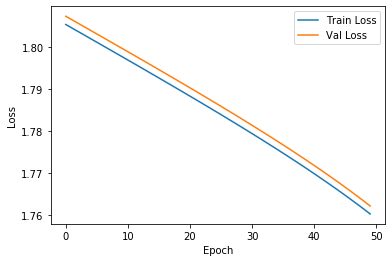

In [8]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

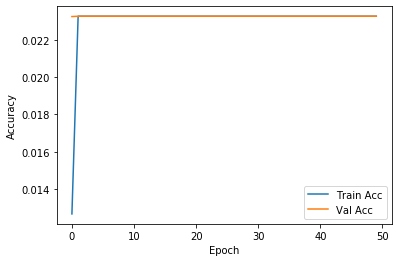

In [9]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

# Run only when recalling new model after restarting kernel
When kernel crashes and for retraining with just 1 epoch

In [6]:
import tensorflow as tf
#Call a saved model
#tf.reset_default_graph()
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.

config_proto = tf.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.Session(config=config_proto)
set_session(session)
with tf.device('/cpu:0'):
    new_model = tf.keras.models.load_model('Project_7500_w2w_s2s_512_40e.h5')

#Run a new model with saved weights
#new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    new_model.summary()

#to reinstate the model, running for just one epoch
    new_history=new_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size,
              epochs=1,
              validation_split=0.2)
# Save model
#new_model.save('revised_Ass3_s2s_100.h5')

W0727 20:49:50.234421  4636 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 6567)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 6463)] 0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 512), (None, 14499840    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 512),  14286848    input_2[0][0]                    
                                                                 lstm_1[0][1]               

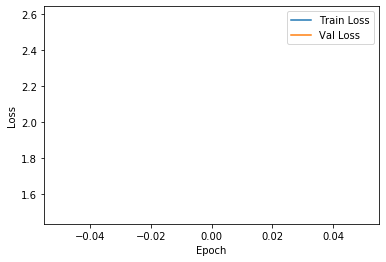

In [70]:
import matplotlib.pyplot as plt
def plot_loss_new_history(new_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(new_history.epoch, np.array(new_history.history['loss']),
               label='Train Loss')
    plt.plot(new_history.epoch, np.array(new_history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_new_history(new_history)

## Inference Mode
Re-tuning the model to accept direct inputs to Decoder along with states from encoder

In [14]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [15]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

Why are we saving h, c from decoder?

In [16]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['START_']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        if (sampled_word != '_END'):
            decoded_sentence += ' '+sampled_word

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [17]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_texts[seq_index])
    print('Decoded sentence:', 'START_ '+decoded_sentence+' _END')

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  _END
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  _END
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  _END
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded sentence: START_  _END
-
Input sentence: I will not eat him.
Target sentence: START_ मैं उसे नहीं खा जाएगा. _END
Decoded sentence: START_  _END
-
Input sentence: You gotta get me to Charleston.
Target sentence: START_ आप चार्ल्सटन करने के लिए मुझे जाना होगा. _END
Decoded sentence: START_  _END
-
Input sentence: - NO, HE'S NOT MY DAD.
Target sentence: START_ - नहीं, वह मेरे पिता नहीं है. _END
Decoded sentence: START_  _END
-
Input sentence: I told her we rest on Sundays.
Targ

# Introducing BLEU score metric at following levels:
# (Individual 1-gram, 2-gram, 3-gram, 4-gram as well as cumulative 4-gram)
## 1. Top 100 samples
## 2. middle 100 samples
## 3. last 100 samples

In [18]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [19]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.188876
Individual 2-gram: 0.171705
Individual 3-gram: 0.151100
Individual 4-gram: 0.125917
4-gram cummulative score:  0.15760767926048347
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.069483
Individual 2-gram: 0.063167
Individual 3-gram: 0.055587
Individual 4-gram: 0.046322
4-gram cummulative score:  0.05798062497067458
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  _END
Individual 1-gram: 0.054114
Individual 2-gram: 0.049194
Individual 3-gram: 0.043291
Individual 4-gram: 0.036076
4-gram cummulative score:  0.045155356130130817
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded s

-
Input sentence: Let's be real hot (nicer) I am of you
Target sentence: START_ चलो तुम हो गरम रियल (अच्छे) का रहा हूँ मैं _END
Decoded sentence: START_  _END
Individual 1-gram: 0.030197
Individual 2-gram: 0.027452
Individual 3-gram: 0.024158
Individual 4-gram: 0.020132
4-gram cummulative score:  0.025198275740375933
-
Input sentence: Look, I know I quit the academy before.
Target sentence: START_ मैं मैं पहले अकादमी छोड़ने पता है, देखो. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.035674
Individual 2-gram: 0.032431
Individual 3-gram: 0.028539
Individual 4-gram: 0.023783
4-gram cummulative score:  0.029768245432152913
-
Input sentence: We village elders still exist.
Target sentence: START_ हम गांव के बुजुर्ग अभी भी मौजूद हैं. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.049787
Individual 2-gram: 0.045261
Individual 3-gram: 0.039830
Individual 4-gram: 0.033191
4-gram cummulative score:  0.04154493319812482
-
Input sentence: It's like a 1 man reign of terror.
Targ

-
Input sentence: Do I eat other's brains?
Target sentence: START_ मैं किसी का दिमाग खाता हूँ? _END
Decoded sentence: START_  _END
Individual 1-gram: 0.105399
Individual 2-gram: 0.095817
Individual 3-gram: 0.084319
Individual 4-gram: 0.070266
4-gram cummulative score:  0.0879506242706027
-
Input sentence: WELL, IT'S A BIT ODD NOT TO.
Target sentence: START_ वैसे, ऐसा नहीं करने के लिए एक अजीब सा है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.032822
Individual 2-gram: 0.029838
Individual 3-gram: 0.026257
Individual 4-gram: 0.021881
4-gram cummulative score:  0.027388107943167136
-
Input sentence: Whatever mistakes I made, I've paid for them and then some.
Target sentence: START_ जो गलतियां मैंने की, उनका भुगतान कर चुका हूं. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.023518
Individual 2-gram: 0.021380
Individual 3-gram: 0.018814
Individual 4-gram: 0.015678
4-gram cummulative score:  0.01962443687865396
-
Input sentence: He asked me for a length of rope.
Target 

-
Input sentence: Hey, they want me to attend this meeting so much they're gonna fly me all the way to New York.
Target sentence: START_ अरे, वे मुझे इस बैठक में भाग लेने के लिए इतना वे ये मुझे न्यूयॉर्क के लिए सभी तरह से उड़ रहे हैं चाहता हूँ. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.000134
Individual 2-gram: 0.000122
Individual 3-gram: 0.000107
Individual 4-gram: 0.000089
4-gram cummulative score:  0.00011192893729570638
-
Input sentence: - Big shots!
Target sentence: START_ - बिग शॉट! _END
Decoded sentence: START_  _END
Individual 1-gram: 0.434598
Individual 2-gram: 0.395089
Individual 3-gram: 0.347679
Individual 4-gram: 0.289732
4-gram cummulative score:  0.36265147019794153
-
Input sentence: Why is this right for you and wrong for me?
Target sentence: START_ क्यों आप के लिए यह सही है और मेरे लिए गलत क्या है? _END
Decoded sentence: START_  _END
Individual 1-gram: 0.015504
Individual 2-gram: 0.014094
Individual 3-gram: 0.012403
Individual 4-gram: 0.010336
4-gram cumm

In [20]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(3450,3550):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I've been away from them for far too long.
Target sentence: START_ मैं उनसे दूर अभी तक बहुत लंबे समय के लिए किया गया है। _END
Decoded sentence: START_  _END
Individual 1-gram: 0.012074
Individual 2-gram: 0.010977
Individual 3-gram: 0.009660
Individual 4-gram: 0.008050
4-gram cummulative score:  0.010075521844875467
-
Input sentence: Hank, he tells me that he's found the answer to your cosmetic problem.
Target sentence: START_ हांक .. वह मुझसे कहता है, वह अपने अंगराग समस्या का जवाब मिल गया है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.003760
Individual 2-gram: 0.003418
Individual 3-gram: 0.003008
Individual 4-gram: 0.002507
4-gram cummulative score:  0.003137549985116177
-
Input sentence: I have to get out of here.
Target sentence: START_ मुझे यहाँ से बाहर निकलना है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.096972
Individual 2-gram: 0.088156
Individual 3-gram: 0.077578
Individual 4-gram: 0.064648
4-gram cummulative score:  0.0809184806233

-
Input sentence: - Will.
Target sentence: START_ ~ ~ करेंगे. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.399850
Individual 2-gram: 0.363500
Individual 3-gram: 0.319880
Individual 4-gram: 0.266566
4-gram cummulative score:  0.3336554596127285
-
Input sentence: Come on, Gobber!
Target sentence: START_ चलो, गॉबर! _END
Decoded sentence: START_  _END
Individual 1-gram: 0.434598
Individual 2-gram: 0.395089
Individual 3-gram: 0.347679
Individual 4-gram: 0.289732
4-gram cummulative score:  0.36265147019794153
-
Input sentence: Young and cocky, good cutter.
Target sentence: START_ युवा और अहंकारी, अच्छा कटर. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.105399
Individual 2-gram: 0.095817
Individual 3-gram: 0.084319
Individual 4-gram: 0.070266
4-gram cummulative score:  0.0879506242706027
-
Input sentence: Oh, and...
Target sentence: START_ ओह, और... _END
Decoded sentence: START_  _END
Individual 1-gram: 0.472367
Individual 2-gram: 0.429424
Individual 3-gram: 0.377893
In

-
Input sentence: You only need one.
Target sentence: START_ आप केवल एक की जरूरत है। _END
Decoded sentence: START_  _END
Individual 1-gram: 0.147096
Individual 2-gram: 0.133724
Individual 3-gram: 0.117677
Individual 4-gram: 0.098064
4-gram cummulative score:  0.12274498402613136
-
Input sentence: Bill... this gonna be a problem?
Target sentence: START_ विधेयक... इस वाला एक समस्या हो सकता है? _END
Decoded sentence: START_  _END
Individual 1-gram: 0.038774
Individual 2-gram: 0.035249
Individual 3-gram: 0.031019
Individual 4-gram: 0.025849
4-gram cummulative score:  0.03235522650734882
-
Input sentence: He is a holy man.
Target sentence: START_ वह एक पवित्र आदमी है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.173774
Individual 2-gram: 0.157976
Individual 3-gram: 0.139019
Individual 4-gram: 0.115849
4-gram cummulative score:  0.14500606500629765
-
Input sentence: I'll bring help.
Target sentence: START_ मैं मदद लाएगा. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.31

-
Input sentence: Thermal.
Target sentence: START_ थर्मल. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.606531
Individual 2-gram: 0.551392
Individual 3-gram: 0.485225
Individual 4-gram: 0.404354
4-gram cummulative score:  0.5061208977839848
-
Input sentence: A local farmer who raised her beloved super pig in wild and beautiful nature.
Target sentence: START_ एक स्थानीय किसान जिसने अपनी प्यारी सूपर सूअर का पालन-पोषण किया जंगल और खूबसूरत प्रकृति के बीच। _END
Decoded sentence: START_  _END
Individual 1-gram: 0.000396
Individual 2-gram: 0.000360
Individual 3-gram: 0.000317
Individual 4-gram: 0.000264
4-gram cummulative score:  0.0003306953354553338
-
Input sentence: Money is not the only thing that matters, Sean.
Target sentence: START_ मनी मामलों, शॉन कि केवल एक चीज नहीं है. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.038774
Individual 2-gram: 0.035249
Individual 3-gram: 0.031019
Individual 4-gram: 0.025849
4-gram cummulative score:  0.03235522650734882
-
Input sen

In [21]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(6900,7000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: What the fuck?
Target sentence: START_ बकवास क्या? अरे यार! _END
Decoded sentence: START_  _END
Individual 1-gram: 0.188876
Individual 2-gram: 0.171705
Individual 3-gram: 0.151100
Individual 4-gram: 0.125917
4-gram cummulative score:  0.15760767926048347
-
Input sentence: It's over?
Target sentence: START_ यह खत्म हो गया है? _END
Decoded sentence: START_  _END
Individual 1-gram: 0.223130
Individual 2-gram: 0.202846
Individual 3-gram: 0.178504
Individual 4-gram: 0.148753
4-gram cummulative score:  0.18619147304196104
-
Input sentence: I can't tell you what that means to me.
Target sentence: START_ मुझे लगता है कि मेरे लिए इसका मतलब क्या आपको नहीं बता सकता. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.007324
Individual 2-gram: 0.006658
Individual 3-gram: 0.005859
Individual 4-gram: 0.004882
4-gram cummulative score:  0.006111112911521366
-
Input sentence: You could have taken all of them two moves earlier.
Target sentence: START_ आप दो कदम पहले उन सभी को भी 

-
Input sentence: YOU'RE A LOUSY SHOT.
Target sentence: START_ आप एक घटिया शॉट हो. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.205290
Individual 2-gram: 0.186627
Individual 3-gram: 0.164232
Individual 4-gram: 0.136860
4-gram cummulative score:  0.17130442482386243
-
Input sentence: Give it back, please.
Target sentence: START_ यह वापस दे दीजिए. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.242521
Individual 2-gram: 0.220474
Individual 3-gram: 0.194017
Individual 4-gram: 0.161681
4-gram cummulative score:  0.2023722660356302
-
Input sentence: "I want to just... kiss you."""
Target sentence: START_ "मैं तो बस ... आप चुंबन करना चाहते हैं।""" _END
Decoded sentence: START_  _END
Individual 1-gram: 0.030197
Individual 2-gram: 0.027452
Individual 3-gram: 0.024158
Individual 4-gram: 0.020132
4-gram cummulative score:  0.025198275740375933
-
Input sentence: - So we don't want you to film.
Target sentence: START_ - इसलिए आप फ़िल्म ना बनाएँ. _END
Decoded sentence: START_  _

-
Input sentence: Anyone at home?
Target sentence: START_ घर पर कोई है? _END
Decoded sentence: START_  _END
Individual 1-gram: 0.338465
Individual 2-gram: 0.307696
Individual 3-gram: 0.270772
Individual 4-gram: 0.225644
4-gram cummulative score:  0.28243324897215305
-
Input sentence: Not 15 minutes
Target sentence: START_ 15 मिनट _END
Decoded sentence: START_  _END
Individual 1-gram: 0.558035
Individual 2-gram: 0.507305
Individual 3-gram: 0.446428
Individual 4-gram: 0.372023
4-gram cummulative score:  0.46565370513333393
-
Input sentence: Look, you need to call us...
Target sentence: START_ देखो,तुम्हेंहमेंफोन ... /मैं चाहताहूँकि _END
Decoded sentence: START_  _END
Individual 1-gram: 0.038774
Individual 2-gram: 0.035249
Individual 3-gram: 0.031019
Individual 4-gram: 0.025849
4-gram cummulative score:  0.03235522650734882
-
Input sentence: There's a surgical kit back at the place, but that's...
Target sentence: START_ घर पर सर्जिकल किट पड़ी है पर वह... _END
Decoded sentence: START_  _EN

-
Input sentence: One whole weekend, you looking after my little girls.
Target sentence: START_ एक पूरे सप्ताहांत, आप मेरी छोटी लड़कियों की तलाश के बाद. _END
Decoded sentence: START_  _END
Individual 1-gram: 0.009404
Individual 2-gram: 0.008549
Individual 3-gram: 0.007523
Individual 4-gram: 0.006269
4-gram cummulative score:  0.00784682430264206
-
Input sentence: (CAR TIRES SQUEALING)
Target sentence: START_ (चिल्ला कार टायर) _END
Decoded sentence: START_  _END
Individual 1-gram: 0.242521
Individual 2-gram: 0.220474
Individual 3-gram: 0.194017
Individual 4-gram: 0.161681
4-gram cummulative score:  0.2023722660356302
-
Input sentence: We haven't had any respect since the day we were born! You want some of our iron?
Target sentence: START_ हम सम्मान नहीं था क्योंकि हम पैदा हुए थे! _END
Decoded sentence: START_  _END
Individual 1-gram: 0.032822
Individual 2-gram: 0.029838
Individual 3-gram: 0.026257
Individual 4-gram: 0.021881
4-gram cummulative score:  0.027388107943167136
-
Input senten

In [22]:
df_bleu=pd.DataFrame()
df_bleu["ip_seq"]=ip_seq
df_bleu["op_seq"]=op_seq
df_bleu["dec_seq"]=dec_seq
df_bleu["bleu_1-gram"]=b1
df_bleu["bleu_2-gram"]=b2
df_bleu["bleu_3-gram"]=b3
df_bleu["bleu_4-gram"]=b4
df_bleu["bleu_cumm_4-gram"]=b_cum

In [23]:
df_bleu.to_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_SGD_Layer_BLEU.csv',index=False)

# After editing the csv to reflect averages

In [24]:
df_bleu_compute=pd.read_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_SGD_Layer_BLEU.csv')

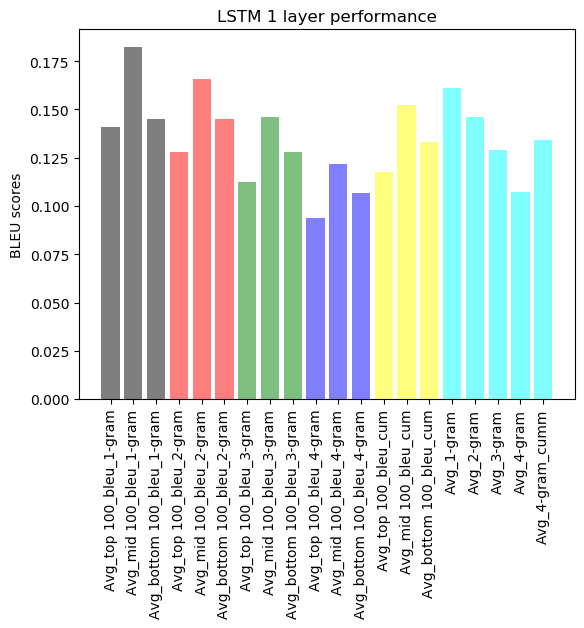

In [25]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Avg_top 100_bleu_1-gram','Avg_mid 100_bleu_1-gram','Avg_bottom 100_bleu_1-gram','Avg_top 100_bleu_2-gram','Avg_mid 100_bleu_2-gram','Avg_bottom 100_bleu_2-gram','Avg_top 100_bleu_3-gram','Avg_mid 100_bleu_3-gram','Avg_bottom 100_bleu_3-gram','Avg_top 100_bleu_4-gram','Avg_mid 100_bleu_4-gram','Avg_bottom 100_bleu_4-gram','Avg_top 100_bleu_cum','Avg_mid 100_bleu_cum','Avg_bottom 100_bleu_cum','Avg_1-gram','Avg_2-gram','Avg_3-gram','Avg_4-gram','Avg_4-gram_cumm')
y_pos = np.arange(len(objects))

performance = [df_bleu_compute['Avg_top 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_1-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_2-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_3-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_4-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_cum'].iloc[0],
               df_bleu_compute['Avg_1-gram'].iloc[0],df_bleu_compute['Avg_2-gram'].iloc[0],df_bleu_compute['Avg_3-gram'].iloc[0],df_bleu_compute['Avg_4-gram'].iloc[0],df_bleu_compute['Avg_4-gram_cumm'].iloc[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['black','black','black', 'red','red','red', 'green','green','green', 'blue', 'blue', 'blue', 'yellow','yellow','yellow','cyan', 'cyan', 'cyan', 'cyan', 'cyan'])
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('BLEU scores')
plt.title('LSTM 1 layer performance')

plt.show()

### The INFERENCE for simple LSTM seq2 seq model saturates very soon and is stubborn towards learning. So we will try to introduces changes to the model

# --------------------------------------------------------------------------------------------------------------
# Refining model
1. Increasinging the learning rate
2. Increasing the momentum
3. Toggling the Nesterov momentum on or off
# -----------------------------------------------------------------------------------------------------------

In [7]:
batch_size = 32  # Batch size for training.
epochs = 70  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 1000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'cleaned_data.txt'
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    index, input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = 'START_ '+target_text+ ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_word_tokens=nltk.word_tokenize(input_text)
    target_word_tokens=nltk.word_tokenize(target_text)

    for word in input_word_tokens:
        if word not in input_words:
            input_words.add(word)
    for word in target_word_tokens:
        if word not in target_words:
            target_words.add(word)
#input_words.add('')
#target_words.add('')
input_words = sorted(list(input_words))

target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(nltk.word_tokenize(txt)) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print('-------Word corpus-------')
#print(input_words)
#print(target_words)

Number of samples: 1000
Number of unique input tokens: 1861
Number of unique output tokens: 1871
Max sequence length for inputs: 29
Max sequence length for outputs: 32
-------Word corpus-------


In [4]:
input_token_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float16')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float16')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(nltk.word_tokenize(input_text)):
        encoder_input_data[i, t, input_token_index[word]] = 1.

    for t, word in enumerate(nltk.word_tokenize(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[word]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [5]:
#EARLY STOPPING
#early_stopping = EarlyStopping(monitor='val_loss', patience=25)
#MODEL CHECKPOINT
ckpt_file = 'sgd_model.h1.29_jul_19'
checkpoint = ModelCheckpoint(ckpt_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
decoder_outputs = Dropout(0.3)(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

W0730 00:36:44.600887  3008 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 00:36:44.614878  3008 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 00:36:44.618840  3008 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 00:36:45.194707  3008 deprecation_wrapper.py:119] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_

In [8]:
# Run training
#model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'],options = run_opts)
#model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['acc'])
model.compile(optimizer=optimizers.sgd(lr=4, momentum=0.6, decay=0.2, nesterov=False), loss='categorical_crossentropy',metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1861)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1871)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 2168832     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  2179072     input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

# Running simple model with 256 latent_dims and batch size 32 for 200 epochs with 0.2 dropout rate

In [9]:
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, callbacks=[checkpoint], verbose=1)
# Save model
#model.save('Ass3_s2s.h5')
model.save('Project_1000_w2w_s2s_64_256_70e.h5')

W0730 00:38:04.472416  3008 deprecation.py:323] From c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 800 samples, validate on 200 samples
Epoch 1/70
800/800 [==============================] - 7s 9ms/step - loss: 2.6862 - acc: 0.0252 - val_loss: 1.7947 - val_acc: 0.0312

Epoch 00001: val_loss improved from inf to 1.79471, saving model to sgd_model.h1.29_jul_19


c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/70
800/800 [==============================] - 4s 4ms/step - loss: 2.5547 - acc: 0.0264 - val_loss: 1.6611 - val_acc: 0.0312

Epoch 00002: val_loss improved from 1.79471 to 1.66105, saving model to sgd_model.h1.29_jul_19
Epoch 3/70
800/800 [==============================] - 4s 5ms/step - loss: 2.4835 - acc: 0.0245 - val_loss: 1.5969 - val_acc: 0.0312

Epoch 00003: val_loss improved from 1.66105 to 1.59690, saving model to sgd_model.h1.29_jul_19
Epoch 4/70
800/800 [==============================] - 4s 5ms/step - loss: 2.4471 - acc: 0.0249 - val_loss: 1.5672 - val_acc: 0.0312

Epoch 00004: val_loss improved from 1.59690 to 1.56720, saving model to sgd_model.h1.29_jul_19
Epoch 5/70
800/800 [==============================] - 4s 5ms/step - loss: 2.4271 - acc: 0.0261 - val_loss: 1.5511 - val_acc: 0.0312

Epoch 00005: val_loss improved from 1.56720 to 1.55108, saving model to sgd_model.h1.29_jul_19
Epoch 6/70
800/800 [==============================] - 4s 4ms/step - loss: 2.3943 - acc: 

800/800 [==============================] - 3s 4ms/step - loss: 2.3876 - acc: 0.0281 - val_loss: 1.4953 - val_acc: 0.0348

Epoch 00038: val_loss improved from 1.49556 to 1.49533, saving model to sgd_model.h1.29_jul_19
Epoch 39/70
800/800 [==============================] - 3s 4ms/step - loss: 2.3865 - acc: 0.0296 - val_loss: 1.4950 - val_acc: 0.0348

Epoch 00039: val_loss improved from 1.49533 to 1.49497, saving model to sgd_model.h1.29_jul_19
Epoch 40/70
800/800 [==============================] - 4s 4ms/step - loss: 2.3723 - acc: 0.0293 - val_loss: 1.4947 - val_acc: 0.0348

Epoch 00040: val_loss improved from 1.49497 to 1.49474, saving model to sgd_model.h1.29_jul_19
Epoch 41/70
800/800 [==============================] - 4s 4ms/step - loss: 2.4133 - acc: 0.0279 - val_loss: 1.4947 - val_acc: 0.0348

Epoch 00041: val_loss improved from 1.49474 to 1.49466, saving model to sgd_model.h1.29_jul_19
Epoch 42/70
800/800 [==============================] - 3s 4ms/step - loss: 2.3968 - acc: 0.0284 

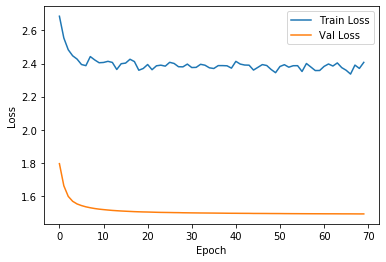

In [10]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.array(history.history['loss']),
               label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

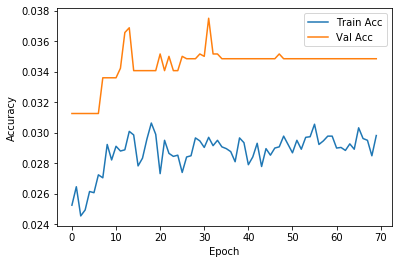

In [11]:
import matplotlib.pyplot as plt
def plot_loss_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['acc']),
               label='Train Acc')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(history)

# Run only when recalling new model after restarting kernel¶
When kernel crashes and for retraining with just 1 epoch

In [ ]:
import tensorflow as tf
#Call a saved model
#resume_complex_model = tf.keras.models.load_model('Ass3_s2s_2000_complex.h5')
resume_complex_model = tf.keras.models.load_model('Ass3_w2w_s2s_250_complex.h5')

resume_complex_model.summary()

#to reinstate the model, running for just one epoch
resume_complex_history=resume_complex_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=1,
          validation_split=0.2)
# Save model
#new_model.save('revised_Ass3_s2s_200_with_space.h5')

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_history(resume_complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['loss']),
               label='Train Loss')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(resume_complex_history)

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_history(resume_complex_history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['acc']),
               label='Train Acc')
    plt.plot(resume_complex_history.epoch, np.array(resume_complex_history.history['val_acc']),
           label = 'Val Acc')
    plt.legend()
    #plt.ylim([0.05, 1])

plot_loss_history(resume_complex_history)

# Revised Model Inference

In [12]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [13]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_word_index = dict(
    (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
    (i, word) for word, i in target_token_index.items())

In [14]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['START_']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while stop_condition == False:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print ('sampled_token_index: ',sampled_token_index)
        sampled_word = reverse_target_word_index[sampled_token_index]
        #print ('sampled_word: ',sampled_word)
        if (sampled_word != '_END'):
            decoded_sentence += ' '+sampled_word
        
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [15]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:', target_texts[seq_index])
    print('Decoded sentence:', 'START_ '+decoded_sentence+' _END')

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की जरुरत है ! _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: I will not eat him.
Target sentence: START_ मैं उसे नहीं खा जाएगा. _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: You gotta get me to Charleston.
Target sentence: START_ आप चार्ल्सटन करने के लिए मुझे जाना होगा. _END
Decoded sentence: START_  मैं मैं , _END
-
Input sentence: - NO, HE'S NOT MY DAD.
Target sentence: START_ - नहीं, वह मेरे पिता नहीं है. _END
Decoded sentence: START_

In [16]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    BLEUscore1 = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights = [1])
    BLEUscore2 = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights = [0.5,0.5])
    BLEUscore3 = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights = [0.33,0.34,0.33])
    BLEUscore4 = nltk.translate.bleu_score.sentence_bleu([target_sentence], decoded_sentence, weights = [0.25,0.25,0.25,0.25])
    print('BLEU score 1 gram',BLEUscore1)
    print('BLEU score 2 gram',BLEUscore2)
    print('BLEU score 3 gram',BLEUscore3)
    print('BLEU score 4 gram',BLEUscore4)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.08864252668986711
BLEU score 2 gram 0.08091918570382325
BLEU score 3 gram 0.07134456738837246
BLEU score 4 gram 0.0644243620250181
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.020023961976195638
BLEU score 2 gram 0.00861694125098847
BLEU score 3 gram 3.984463780026941e-104
BLEU score 4 gram 2.5295785065619195e-156
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.012361763235169694
BLEU score 2 gram 0.008241175490113129
BLEU score 3 gram 3.518049340047986e-104
BLEU score 4 gram 2.1292271991888837e-156
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की ज

c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


START_ - तुम बस की तरह है कि एक आदमी को मार नहीं है! _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.007276221681356653
BLEU score 2 gram 0.0038349055455644907
BLEU score 3 gram 1.511356918597577e-104
BLEU score 4 gram 8.809626965736759e-157
-
Input sentence: You sent these?
Target sentence: START_ आप इन भेजा? _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.0817595379102038
BLEU score 2 gram 2.2266400512599746e-155
BLEU score 3 gram 1.3664317878494914e-207
BLEU score 4 gram 3.6745639565236594e-232
-
Input sentence: I really loved him.
Target sentence: START_ मैं वास्तव में उसे प्यार करता था। _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.0241579067378548
BLEU score 2 gram 0.022053050770715194
BLEU score 3 gram 0.01768268861793112
BLEU score 4 gram 0.014764195972465536
-
Input sentence: I ain't much at guessing games.
Target sentence: START_ मैं अनुमान लगाने के खेल में ज्यादा नहीं है. _END
Decoded sentence: START_  मैं मैं , _END
BL

c:\users\robustus\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


-
Input sentence: - It's not personal.
Target sentence: START_ -यह कोई निजी दुश्मनी नहीं। _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.030405031312608986
BLEU score 2 gram 6.414054836010187e-156
BLEU score 3 gram 3.608746046850175e-208
BLEU score 4 gram 9.315931259842069e-233
-
Input sentence: Will I have enough time to do it? The poison takes effect after 1 or 2 seconds.
Target sentence: START_ जहर का प्रभाव होता है 1 या 2 सेकंड के बाद. _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.006138669951534218
BLEU score 2 gram 1.2949753376172368e-156
BLEU score 3 gram 7.285932611860275e-209
BLEU score 4 gram 1.880854083239676e-233
-
Input sentence: - Did you file the football yet?
Target sentence: START_ - अगर आप अभी तक फुटबॉल दायर की थी? _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.00819711673418777
BLEU score 2 gram 2.232403569262095e-156
BLEU score 3 gram 1.3699687107587348e-208
BLEU score 4 gram 3.6840753346655297e-233
-
Input s

-
Input sentence: For the lady!
Target sentence: START_ महिला के लिए! _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.08925206405937193
BLEU score 2 gram 0.04703996804981149
BLEU score 3 gram 2.330339965622961e-103
BLEU score 4 gram 1.5282164258101107e-155
-
Input sentence: Keep coming.
Target sentence: START_ आते रहना. _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.09986132510942386
BLEU score 2 gram 2.719624300038834e-155
BLEU score 3 gram 1.6689635545171006e-207
BLEU score 4 gram 4.488122551533943e-232
-
Input sentence: I will find you!
Target sentence: START_ मैं तुम्हें मिल जाएगा! _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.07257436263153001
BLEU score 2 gram 0.06625102584974829
BLEU score 3 gram 0.05841199138590501
BLEU score 4 gram 0.04766157781957327
-
Input sentence: Our agency passed suspension order against him
Target sentence: START_ हमारे एजेंसी उनके खिलाफ निलंबन आदेश पारित _END
Decoded sentence: START_  मैं मैं , 

Target sentence: START_ धन्यवाद, एलेक्स! _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.06611955528863463
BLEU score 2 gram 1.559452474871608e-155
BLEU score 3 gram 9.113191549181549e-208
BLEU score 4 gram 2.3949323699607068e-232
-
Input sentence: Transportation is waiting for you.
Target sentence: START_ परिवहन आप के लिए इंतज़ार कर रहा है। _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.012361763235169694
BLEU score 2 gram 2.6077600922342056e-156
BLEU score 3 gram 1.4672066523581073e-208
BLEU score 4 gram 3.7875750024808e-233
-
Input sentence: How much do I get out of it?
Target sentence: START_ मैं इसे से बाहर निकलना है? _END
Decoded sentence: START_  मैं मैं , _END
BLEU score 1 gram 0.04256704383765258
BLEU score 2 gram 0.033918232406369105
BLEU score 3 gram 0.02968561605184425
BLEU score 4 gram 0.025983349617896907
-
Input sentence: Your bloody pills are making me feel like shit.
Target sentence: START_ तुम्हारी दवाइयां मुझे बीमार बना रही हैं. _

In [17]:
ip_seq=[]
op_seq=[]
dec_seq=[]
b1=[]
b2=[]
b3=[]
b4=[]
b_cum=[]

In [18]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: I do not want to die.
Target sentence: START_ मैं मरना नहीं चाहता. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.577033
Individual 2-gram: 0.483609
Individual 3-gram: 0.380842
Individual 4-gram: 0.300665
4-gram cummulative score:  0.422795598767736
-
Input sentence: It's the same country I think.
Target sentence: START_ यह मुझे लगता है कि एक ही देश है. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.300992
Individual 2-gram: 0.192699
Individual 3-gram: 0.147152
Individual 4-gram: 0.116172
4-gram cummulative score:  0.1774498889766137
-
Input sentence: Then they'll be crying like babies.
Target sentence: START_ फिर ये नन्हें बच्चों की तरह रोएँगे। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.248033
Individual 2-gram: 0.183419
Individual 3-gram: 0.128394
Individual 4-gram: 0.101363
4-gram cummulative score:  0.15598936905685615
-
Input sentence: - No, I need power up!
Target sentence: START_ नहीं, मुझे पावर की

Individual 2-gram: 0.111194
Individual 3-gram: 0.093403
Individual 4-gram: 0.073739
4-gram cummulative score:  0.10998183919508076
-
Input sentence: Let's be real hot (nicer) I am of you
Target sentence: START_ चलो तुम हो गरम रियल (अच्छे) का रहा हूँ मैं _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.201665
Individual 2-gram: 0.155671
Individual 3-gram: 0.128429
Individual 4-gram: 0.098319
4-gram cummulative score:  0.14110214620973766
-
Input sentence: Look, I know I quit the academy before.
Target sentence: START_ मैं मैं पहले अकादमी छोड़ने पता है, देखो. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.255729
Individual 2-gram: 0.231374
Individual 3-gram: 0.191797
Individual 4-gram: 0.161513
4-gram cummulative score:  0.20691217962990405
-
Input sentence: We village elders still exist.
Target sentence: START_ हम गांव के बुजुर्ग अभी भी मौजूद हैं. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.278837
Individual 2-gram: 0.175269
I

-
Input sentence: Our agency passed suspension order against him
Target sentence: START_ हमारे एजेंसी उनके खिलाफ निलंबन आदेश पारित _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.199935
Individual 2-gram: 0.116364
Individual 3-gram: 0.097746
Individual 4-gram: 0.077168
4-gram cummulative score:  0.11509637252670185
-
Input sentence: I need.. I need to call my wife.
Target sentence: START_ - मुझे अपनी पत्नी को फ़ोन करना है। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.259568
Individual 2-gram: 0.175953
Individual 3-gram: 0.134364
Individual 4-gram: 0.106077
4-gram cummulative score:  0.1597307458228419
-
Input sentence: Do I eat other's brains?
Target sentence: START_ मैं किसी का दिमाग खाता हूँ? _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.398786
Individual 2-gram: 0.307835
Individual 3-gram: 0.253964
Individual 4-gram: 0.194422
4-gram cummulative score:  0.2790252420759224
-
Input sentence: WELL, IT'S A BIT ODD NOT TO.
Targ

-
Input sentence: Your bloody pills are making me feel like shit.
Target sentence: START_ तुम्हारी दवाइयां मुझे बीमार बना रही हैं. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.232481
Individual 2-gram: 0.158309
Individual 3-gram: 0.115078
Individual 4-gram: 0.080757
4-gram cummulative score:  0.1359927123706242
-
Input sentence: Hey, they want me to attend this meeting so much they're gonna fly me all the way to New York.
Target sentence: START_ अरे, वे मुझे इस बैठक में भाग लेने के लिए इतना वे ये मुझे न्यूयॉर्क के लिए सभी तरह से उड़ रहे हैं चाहता हूँ. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.012166
Individual 2-gram: 0.009270
Individual 3-gram: 0.005475
Individual 4-gram: 0.003842
4-gram cummulative score:  0.006978849949248567
-
Input sentence: - Big shots!
Target sentence: START_ - बिग शॉट! _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.636364
Individual 2-gram: 0.476190
Individual 3-gram: 0.400000
Individual 4-gram:

In [19]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(450,550):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: Those guys, they just don't know how much I love 'em.
Target sentence: START_ उन लोगों को, वे तो बस मैं उन्हें कितना प्यार करता हूँ पता नहीं है. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.074872
Individual 2-gram: 0.059762
Individual 3-gram: 0.043141
Individual 4-gram: 0.033026
4-gram cummulative score:  0.05024839927396918
-
Input sentence: Were you watching me?
Target sentence: START_ तुम मुझे देख रहे थे? _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.490478
Individual 2-gram: 0.332481
Individual 3-gram: 0.253895
Individual 4-gram: 0.200443
4-gram cummulative score:  0.30182675548217774
-
Input sentence: Tonight we must Make a decision.
Target sentence: START_ आज रात हम ... ... फैसला करें. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.344967
Individual 2-gram: 0.200774
Individual 3-gram: 0.168650
Individual 4-gram: 0.133145
4-gram cummulative score:  0.19858641488087198
-
Input sentence: We had all of 

-
Input sentence: What do we do now? We wait.
Target sentence: START_ क्या बाघों से सपना वे थोड़ी शेर दिन में झपकी लेना जब ले. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.101107
Individual 2-gram: 0.076499
Individual 3-gram: 0.049430
Individual 4-gram: 0.039024
4-gram cummulative score:  0.06214949445731121
-
Input sentence: Terrible thing.
Target sentence: START_ एक भयानक बात . _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.568468
Individual 2-gram: 0.397025
Individual 3-gram: 0.333501
Individual 4-gram: 0.263290
4-gram cummulative score:  0.3752010957103088
-
Input sentence: Write your exams.
Target sentence: START_ अपना एग्जाम दो. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.543207
Individual 2-gram: 0.379383
Individual 3-gram: 0.318681
Individual 4-gram: 0.251591
4-gram cummulative score:  0.35852829822812976
-
Input sentence: It's from 1910.
Target sentence: START_ यह 1910 से है। _END
Decoded sentence: START_  मैं मै

-
Input sentence: I'm gonna get you there.
Target sentence: START_ मैं तुम्हें वहाँ मिल रहा है। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.421177
Individual 2-gram: 0.336178
Individual 3-gram: 0.242678
Individual 4-gram: 0.185782
4-gram cummulative score:  0.28266188153824057
-
Input sentence: JUST TAKE THIS...
Target sentence: START_ सिर्फ यह लो... _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.530570
Individual 2-gram: 0.397025
Individual 3-gram: 0.333501
Individual 4-gram: 0.263290
4-gram cummulative score:  0.36878503731684426
-
Input sentence: - Quil, you too? - Yep. Finally made the pack.
Target sentence: START_ हाँ, अंत में पैक किया. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.526889
Individual 2-gram: 0.358787
Individual 3-gram: 0.231831
Individual 4-gram: 0.183025
4-gram cummulative score:  0.2992673610793161
-
Input sentence: Sir, we have nuclear missiles spinning up on the Albuquerque.
Target sentence: START_

Individual 1-gram: 0.271638
Individual 2-gram: 0.184136
Individual 3-gram: 0.140613
Individual 4-gram: 0.111010
4-gram cummulative score:  0.16715877420984276
-
Input sentence: Krypton had its chance.
Target sentence: START_ क्रिप्टन अपने मौका है. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.447856
Individual 2-gram: 0.303589
Individual 3-gram: 0.231831
Individual 4-gram: 0.183025
4-gram cummulative score:  0.27559822662392774
-
Input sentence: Are you yuck and she's a queen?
Target sentence: START_ क्या ये सब छी है और वो एक राजकुमारी है? _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.218963
Individual 2-gram: 0.127439
Individual 3-gram: 0.107049
Individual 4-gram: 0.084512
4-gram cummulative score:  0.12605002983167377
-
Input sentence: - It's true!
Target sentence: START_ यह सच है! _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.681818
Individual 2-gram: 0.476190
Individual 3-gram: 0.400000
Individual 4-gram: 0.315789
4-gra

In [20]:
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
for seq_index in range(900,1000):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    target_sentence = target_texts[seq_index]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Target sentence:',target_sentence)
    print('Decoded sentence:','START_ '+decoded_sentence+' _END')
    x1=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(1, 0, 0, 0))
    print('Individual 1-gram: %f' % x1)
    x2=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 1, 0, 0))
    print('Individual 2-gram: %f' % x2)
    x3=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0, 0, 1, 0))
    print('Individual 3-gram: %f' % x3)
    x4=sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0,0,0,1))
    print('Individual 4-gram: %f' % x4)
    score = sentence_bleu([target_sentence], 'START_ '+decoded_sentence+' _END', weights=(0.25, 0.25, 0.25, 0.25))
    print('4-gram cummulative score: ',score)
    ip_seq.append(input_texts[seq_index])
    op_seq.append(target_sentence)
    dec_seq.append('START_ '+decoded_sentence+' _END')
    b1.append(x1)
    b2.append(x2)
    b3.append(x3)
    b4.append(x4)
    b_cum.append(score)

-
Input sentence: This hellfire club, it's got to be something else.
Target sentence: START_ वहाँ कुछ और होगा. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.496003
Individual 2-gram: 0.346415
Individual 3-gram: 0.290988
Individual 4-gram: 0.229728
4-gram cummulative score:  0.32737244591956594
-
Input sentence: Stay behind me.
Target sentence: START_ मेरे पीछे रहें। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.579421
Individual 2-gram: 0.417321
Individual 3-gram: 0.318681
Individual 4-gram: 0.251591
4-gram cummulative score:  0.37314600122213337
-
Input sentence: Oh, Christ.
Target sentence: START_ ओह, भगवान. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.636364
Individual 2-gram: 0.523810
Individual 3-gram: 0.400000
Individual 4-gram: 0.315789
4-gram cummulative score:  0.45298528719709075
-
Input sentence: - Come here, you son-of-a-bitch!
Target sentence: START_ यहाँ आओ, तुम दामाद की एक कुतिया! _END
Decoded sentence: STAR

-
Input sentence: - A few minutes.
Target sentence: START_ मिनट ~ कुछ 10 मई _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.588278
Individual 2-gram: 0.435029
Individual 3-gram: 0.304520
Individual 4-gram: 0.240411
4-gram cummulative score:  0.3699708510142631
-
Input sentence: Marry me.
Target sentence: START_ मुझसे शादी कर लो. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.529069
Individual 2-gram: 0.381056
Individual 3-gram: 0.290988
Individual 4-gram: 0.229728
4-gram cummulative score:  0.34071988099379197
-
Input sentence: Good morning, Mr. Secretary.
Target sentence: START_ सेक्रेटरी। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.545455
Individual 2-gram: 0.476190
Individual 3-gram: 0.400000
Individual 4-gram: 0.315789
4-gram cummulative score:  0.4255976564088323
-
Input sentence: She was a good mother to you, wasn't she?
Target sentence: START_ वह एक अच्छी माँ थी न? _END
Decoded sentence: START_  मैं मैं , _END
Individ

-
Input sentence: - Baby, I'm getting tired of this.
Target sentence: START_ - बेबी, मैं इस के थक गया हो रही है. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.291804
Individual 2-gram: 0.229274
Individual 3-gram: 0.176541
Individual 4-gram: 0.135151
4-gram cummulative score:  0.19988404610696556
-
Input sentence: Get them while they're cold.
Target sentence: START_ गर्म होने से पहले खा लो। _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.384882
Individual 2-gram: 0.252006
Individual 3-gram: 0.211685
Individual 4-gram: 0.167120
4-gram cummulative score:  0.24202748962650486
-
Input sentence: - These scars are like mine.
Target sentence: START_ निशान ~ ये मेरी पसंद कर रहे हैं ~. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.290105
Individual 2-gram: 0.207945
Individual 3-gram: 0.151160
Individual 4-gram: 0.106077
4-gram cummulative score:  0.17635610027041781
-
Input sentence: We embrace the trials of our lives...
Target sentenc

Target sentence: START_ उन लोगों की संख्या प्राप्त करें! _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.284270
Individual 2-gram: 0.192699
Individual 3-gram: 0.147152
Individual 4-gram: 0.116172
4-gram cummulative score:  0.17493223143356415
-
Input sentence: - No, you can't do that, I won't let you.
Target sentence: START_ - नहीं, तुम ऐसा नहीं कर सकते, मैं तुम्हें जाने नहीं देंगे. _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.107707
Individual 2-gram: 0.085970
Individual 3-gram: 0.062060
Individual 4-gram: 0.047510
4-gram cummulative score:  0.07228488550523063
-
Input sentence: Damn it, you're putting me behind!
Target sentence: START_ बस करो, डुफ्रेन, तुम देरी करा रहे हो! _END
Decoded sentence: START_  मैं मैं , _END
Individual 1-gram: 0.226479
Individual 2-gram: 0.153524
Individual 3-gram: 0.117236
Individual 4-gram: 0.092555
4-gram cummulative score:  0.13936911577932665
-
Input sentence: If it's me you want, here I am.
Target sentence: STA

In [21]:
df_bleu=pd.DataFrame()
df_bleu["ip_seq"]=ip_seq
df_bleu["op_seq"]=op_seq
df_bleu["dec_seq"]=dec_seq
df_bleu["bleu_1-gram"]=b1
df_bleu["bleu_2-gram"]=b2
df_bleu["bleu_3-gram"]=b3
df_bleu["bleu_4-gram"]=b4
df_bleu["bleu_cumm_4-gram"]=b_cum

In [22]:
df_bleu.to_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_SGD_Dropout_Layer_BLEU.csv',index=False)

# After editing the csv to reflect average values

In [3]:
df_bleu_compute=pd.read_csv('G:\\CSUEB\\MSBA\\Summer 19\\DL_BAN676\\Project\\LSTM_SGD_Dropout_Layer_BLEU.csv')

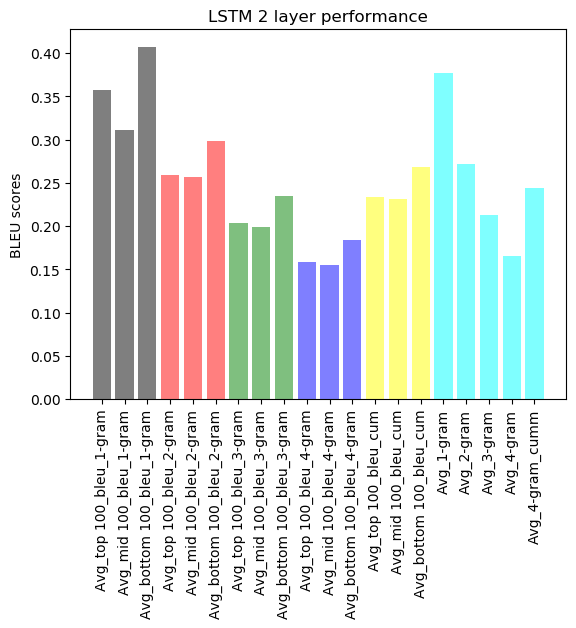

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Avg_top 100_bleu_1-gram','Avg_mid 100_bleu_1-gram','Avg_bottom 100_bleu_1-gram','Avg_top 100_bleu_2-gram','Avg_mid 100_bleu_2-gram','Avg_bottom 100_bleu_2-gram','Avg_top 100_bleu_3-gram','Avg_mid 100_bleu_3-gram','Avg_bottom 100_bleu_3-gram','Avg_top 100_bleu_4-gram','Avg_mid 100_bleu_4-gram','Avg_bottom 100_bleu_4-gram','Avg_top 100_bleu_cum','Avg_mid 100_bleu_cum','Avg_bottom 100_bleu_cum','Avg_1-gram','Avg_2-gram','Avg_3-gram','Avg_4-gram','Avg_4-gram_cumm')
y_pos = np.arange(len(objects))

performance = [df_bleu_compute['Avg_top 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_1-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_1-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_2-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_2-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_3-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_3-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_4-gram'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_4-gram'].iloc[0],
               df_bleu_compute['Avg_top 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_mid 100_bleu_cum'].iloc[0],df_bleu_compute['Avg_bottom 100_bleu_cum'].iloc[0],
               df_bleu_compute['Avg_1-gram'].iloc[0],df_bleu_compute['Avg_2-gram'].iloc[0],df_bleu_compute['Avg_3-gram'].iloc[0],df_bleu_compute['Avg_4-gram'].iloc[0],df_bleu_compute['Avg_4-gram_cumm'].iloc[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5, color=['black','black','black', 'red','red','red', 'green','green','green', 'blue', 'blue', 'blue', 'yellow','yellow','yellow','cyan', 'cyan', 'cyan', 'cyan', 'cyan'])
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('BLEU scores')
plt.title('LSTM 2 layer performance')

plt.show()